# ex3-qal9000 Demo: StateTomography on QAL9000

This demonstration was given at QC Norway event given in December 2022. The demonstration can be viewed on youtube [here](https://www.youtube.com/watch?v=PP3F9pcZgL8). A blog post was written about the event [here](https://nordiquest.net/_posts/2022-12-13-Nordiquest_QC_Norway/).



## Import necessary libraries

In [1]:
%matplotlib inline

In [2]:
import contextlib
import time
from datetime import datetime
from os import environ, listdir, makedirs
from pathlib import Path
from shutil import move

import matplotlib.pyplot as plt
import numpy as np
import qiskit.circuit as circuit
import qiskit.compiler as compiler
from qiskit.ignis.verification.tomography import (
    StateTomographyFitter,
    state_tomography_circuits,
)
from qiskit.providers.fake_provider import FakeManilaV2
from qiskit.providers.jobstatus import JobStatus
from qiskit.visualization import plot_bloch_multivector
from tqdm.auto import tqdm

/tmp/ipykernel_1294217/3671260052.py:7: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification.tomography import StateTomographyFitter
/home/jmujake/miniconda3/envs/nq-application-library/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setting environment variables

In [3]:
API_URL = environ.get("QAL9000_API_URL", default="https://api.qal9000.se")
API_TOKEN = environ.get("QAL9000_API_TOKEN")
# the name of this service. For your own bookkeeping.
SERVICE_NAME = "local"

folder = Path("demo_bloch_frames").resolve()

Function to save old frames

In [4]:
def save_old_frames():
    global folder
    saved_folder = folder / "saved_animations"
    makedirs(saved_folder, exist_ok=True)

    old_frames = [f for f in listdir(folder) if f.endswith(".jpg")]

    if len(old_frames):
        now_time = datetime.now()
        mstr = now_time.strftime("%Y%m%d%H%M%S")
        new_dir = saved_folder / mstr
        makedirs(new_dir, exist_ok=True)
        for f in old_frames:
            move(folder / f, new_dir / f)


save_old_frames()

## Initialize the account and backend 

In [5]:
# account = ProviderAccount(service_name=SERVICE_NAME, url=API_URL, token=API_TOKEN)
# chalmers = Tergite.use_provider_account(account)
# backend = chalmers.get_backend("Nov7")
# backend.set_options(shots=2000)

backend = FakeManilaV2()

print(f"Loaded backend {backend.name} (QAL 9000)")

Loaded backend fake_manila_v2 (QAL 9000)


## Build StateTomography circuits

In [6]:
# Define theta values
thetadef = -1 * np.asarray([0, np.pi / 2, np.pi])


# Function to generate tomography circuits
def tomog_circs(theta):
    q = circuit.QuantumRegister(1)
    circ = circuit.QuantumCircuit(q)
    circ.barrier([0])
    circ.reset([0])
    circ.rx(theta, q[0])
    return state_tomography_circuits(circ, [q[0]])

In [7]:
print("Transpiling...")
with contextlib.redirect_stderr(None):
    precomputed_tomog_circs = [
        compiler.transpile(tomog_circs(theta), backend=backend) for theta in thetadef
    ]

Transpiling...


In [8]:
def compute_new_frame(j: int):
    job = backend.run(precomputed_tomog_circs[j], meas_level=2, meas_return="single")
    while job.status() != JobStatus.DONE:
        time.sleep(1)  # blocking wait

    # fit state vector when result is ready
    fitter = StateTomographyFitter(job.result(), precomputed_tomog_circs[j])

    density_matrix = fitter.fit(method="lstsq")

    # compute frame and save to main memory
    plot = plot_bloch_multivector(density_matrix, reverse_bits=True)
    display(plot)
    plt.show()

Reconstructing qubit state:   0%|          | 0/3 [00:00<?, ?it/s]

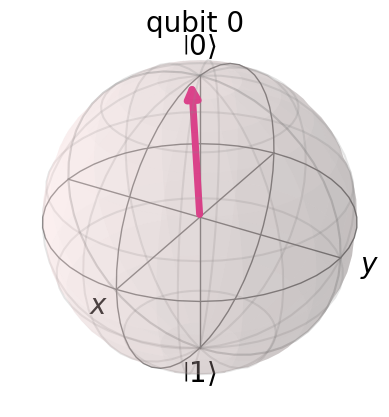

Reconstructing qubit state:  33%|███▎      | 1/3 [00:00<00:01,  1.29it/s]

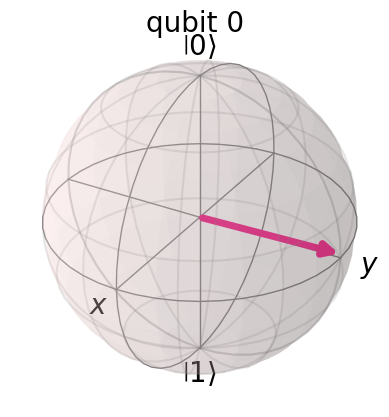

Reconstructing qubit state:  67%|██████▋   | 2/3 [00:01<00:00,  1.42it/s]

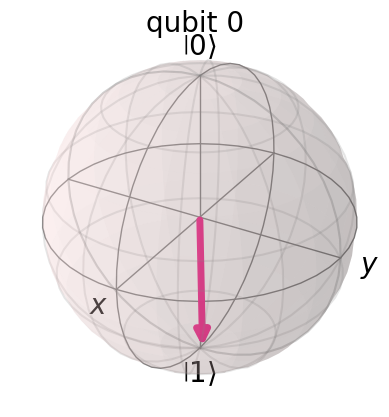

Reconstructing qubit state: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


In [11]:
# progress bar
for j in tqdm(range(len(thetadef)), desc="Reconstructing qubit state"):
    compute_new_frame(j)